In [1]:
from helper.synthesis import create_features_linspace
%load_ext autoreload
%autoreload 2

import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
os.getcwd()

'/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code'

In [2]:
from analysis.gridbased import model

In [3]:
model_type = 'dense'
parameterization = 'svensson'
models = model.init_model(model_type = model_type, parameterization = parameterization)

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  300       
                                                                 
 dense_1 (Dense)             multiple                  930       
                                                                 
 dense_2 (Dense)             multiple                  930       
                                                                 
 dense_3 (Dense)             multiple                  1953      
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
Total params: 4,113
Trainable params: 4,113
Non-trainable params: 0
_________________________________________________________________


In [4]:
import os
os.getcwd()

'/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code'

100%|██████████| 200/200 [04:10<00:00,  1.25s/it]


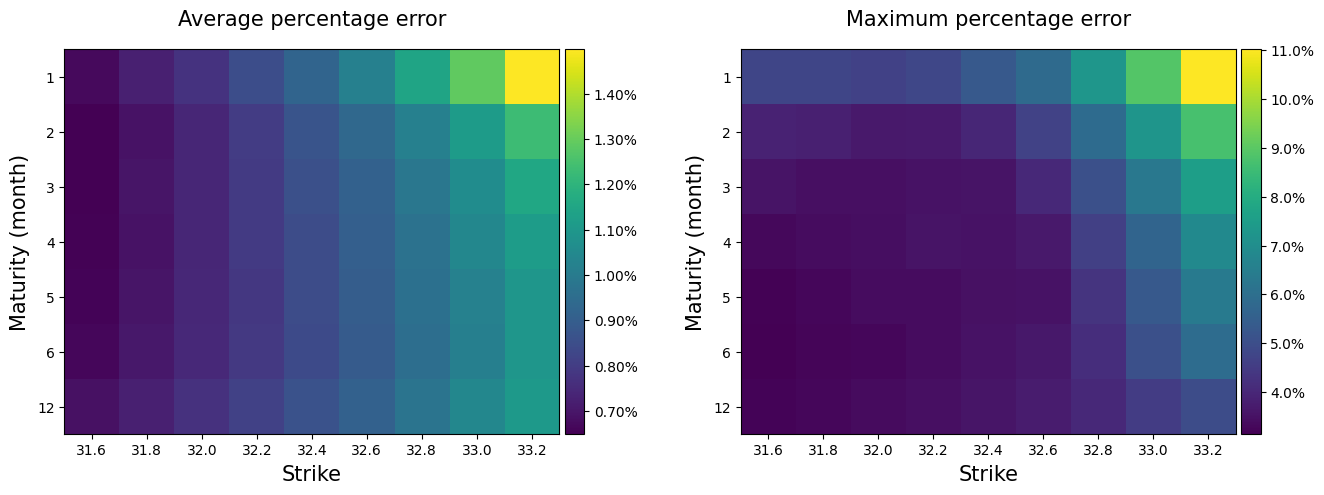

In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
# print(os.getcwd())
model.train_model(models, epochs = 200, model_type = model_type, parameterization = parameterization)

In [6]:
model.load_weights(models, model_type = model_type, parameterization = parameterization)

In [7]:
params_range_train, params_range_test, price_train, price_test = model.load_data(parameterization = parameterization)

100%|██████████| 500/500 [00:05<00:00, 84.57it/s] 


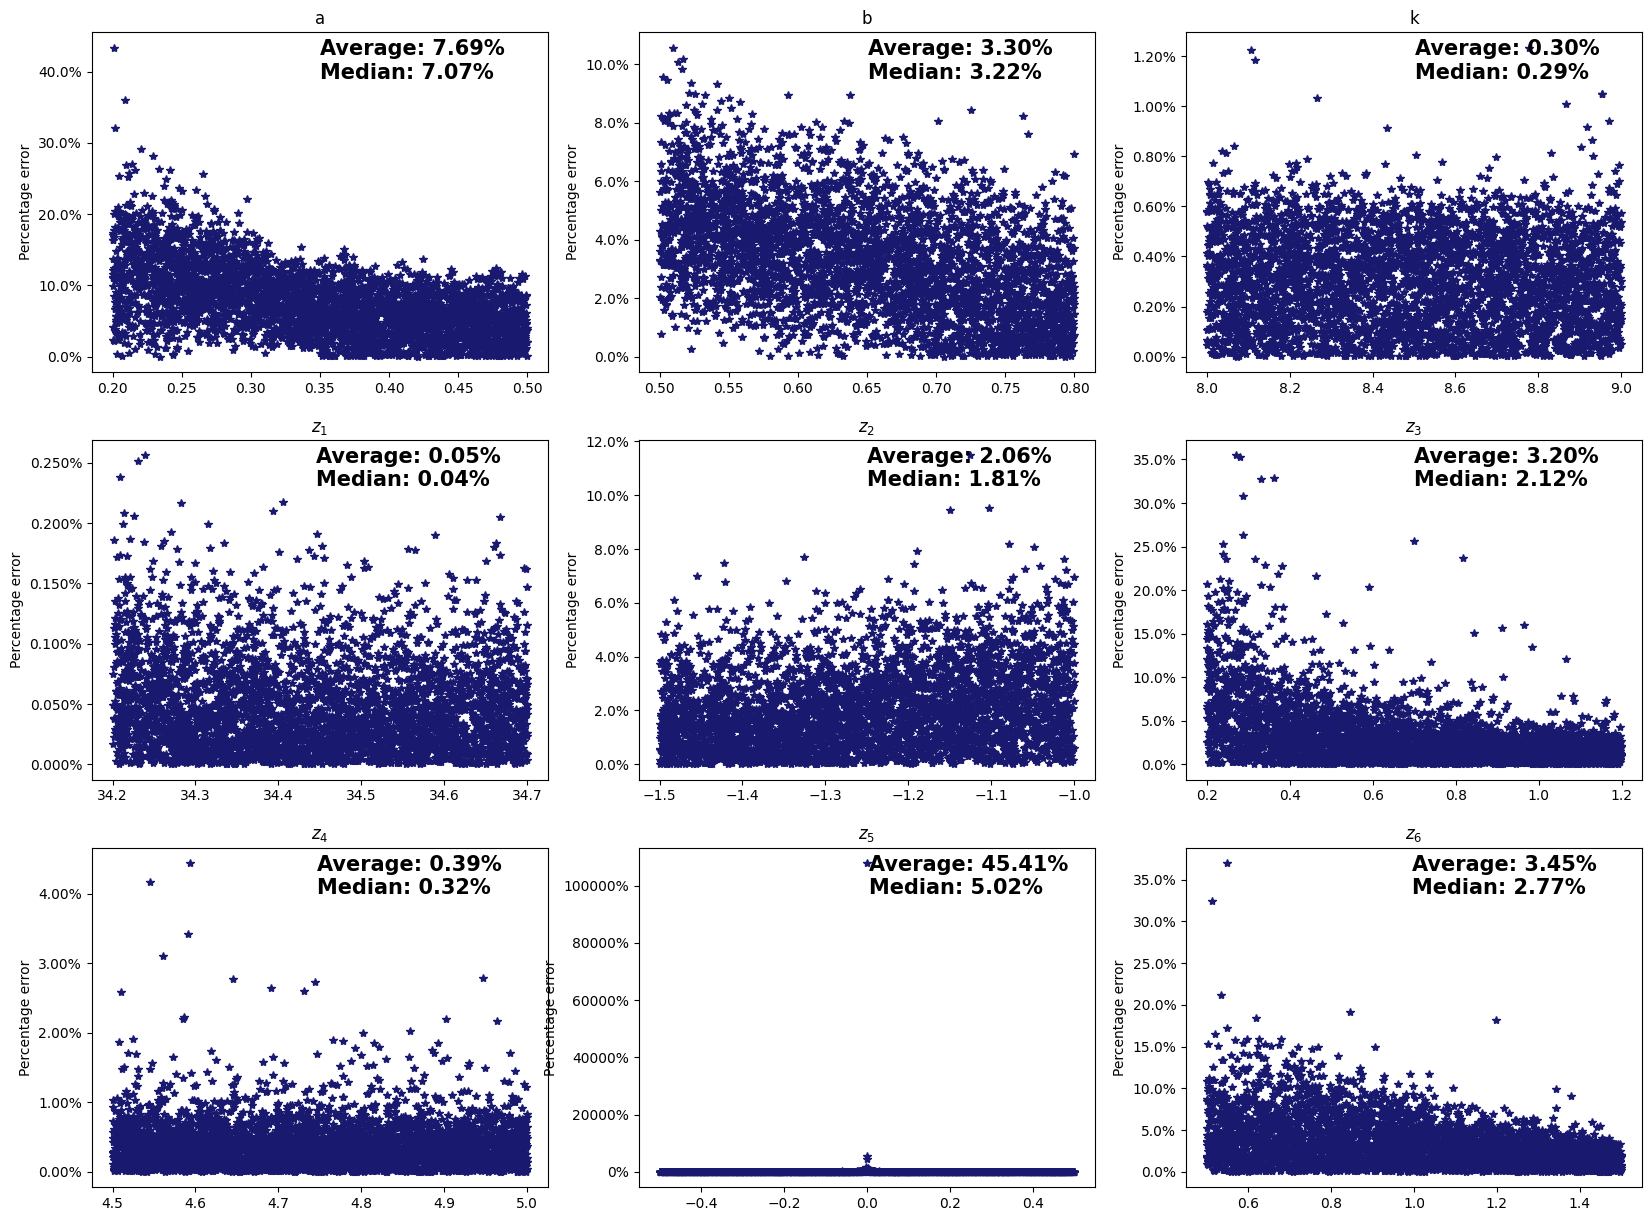

In [8]:
model.calibrate(model = models, prices = price_test, parameters = params_range_test, epochs = 500, model_type = model_type, parameterization = parameterization, plot = True)

In [8]:
params_range_test.shape

(4000, 9)

In [1]:
from helper.synthesis import create_features_linspace
%load_ext autoreload
%autoreload 2


In [2]:
from analysis.pointwise import model as pointwise_model

In [3]:
import os
os.getcwd()

'/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code'

In [4]:
parameterization = 'nelson_siegel'
pointwise_models = pointwise_model.init_model(model_type = 'dense', parameterization = parameterization)

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  300       
                                                                 
 dense_1 (Dense)             multiple                  930       
                                                                 
 dense_2 (Dense)             multiple                  930       
                                                                 
 dense_3 (Dense)             multiple                  31        
                                                                 
Total params: 2,191
Trainable params: 2,191
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 250/250 [02:54<00:00,  1.43it/s]


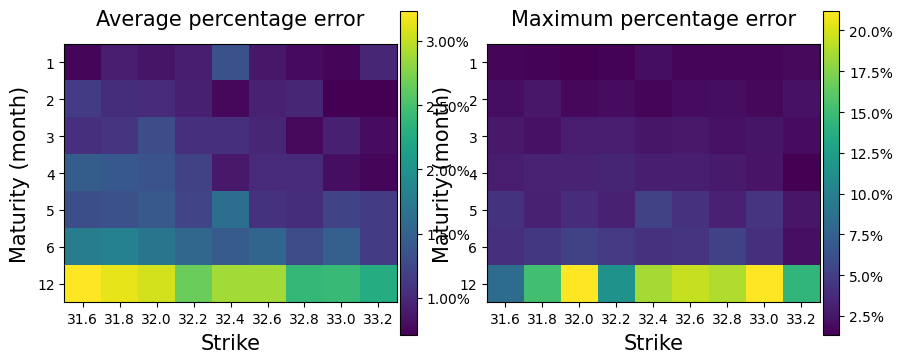

In [6]:
pointwise_model.train_model(pointwise_models, epochs = 250, model_type = 'dense', parameterization = parameterization)

In [8]:
pointwise_model.load_weights(pointwise_models, parameterization = parameterization)
params_range_train, params_range_test, price_train, price_test = pointwise_model.load_data(parameterization = parameterization)

100%|██████████| 4000/4000 [1:34:40<00:00,  1.42s/it]    


[[32.05840695  0.76187139  0.45573115 ... -1.31726238  0.40042728
   4.79928484]
 [31.99898786  0.09816689  0.30052425 ... -1.35730087  0.73570509
   4.82377006]
 [32.61339717  0.3311982   0.4924908  ... -1.19306353  0.8904044
   4.55283413]
 ...
 [32.31201079  0.19208498  0.32529281 ... -1.44587039  0.63497629
   4.61034258]
 [32.84273398  0.7404544   0.3721117  ... -1.10416824  1.00826982
   4.87543751]
 [31.85246443  0.60585514  0.4112532  ... -1.08488007  0.39313929
   4.63998697]]


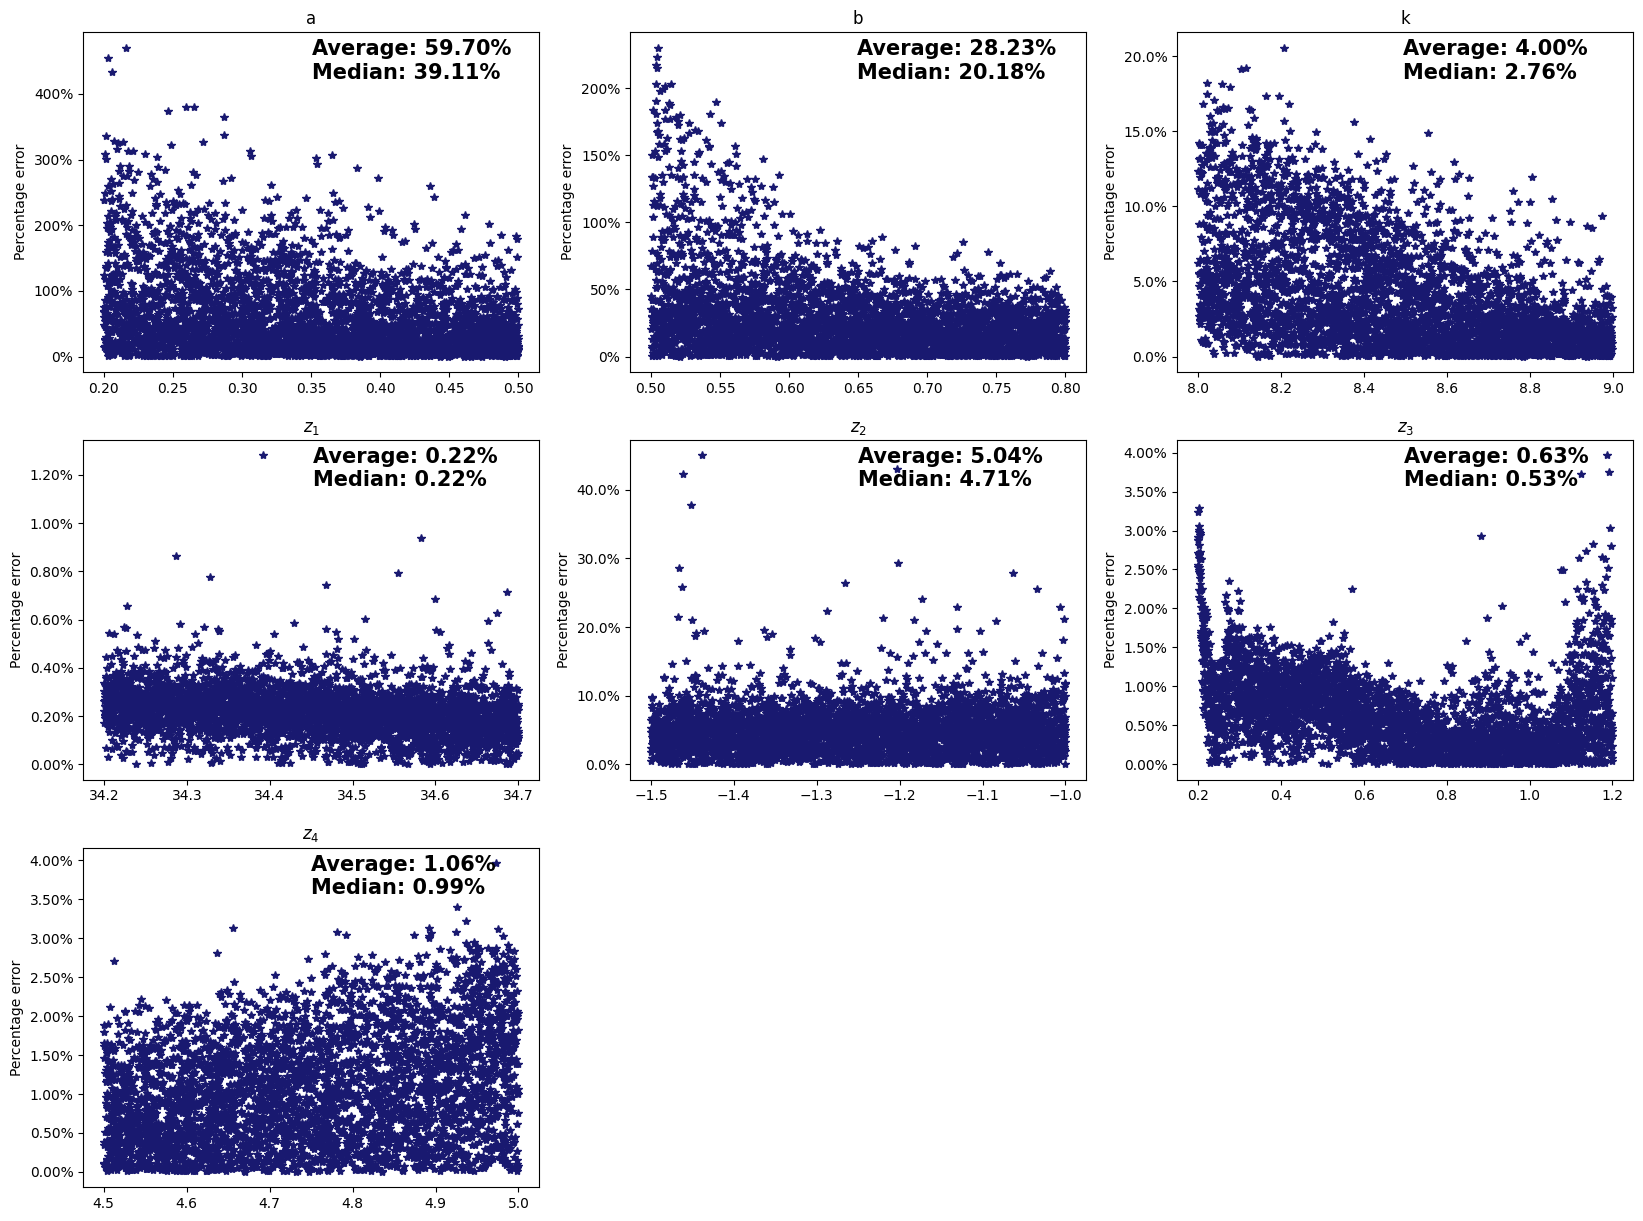

In [15]:
pointwise_model.calibrate(model = pointwise_models, prices = price_test, parameters = params_range_test, parameterization = parameterization, plot = True
                )

In [7]:
params_range_test.s

(4000, 9)

In [15]:
from helper.parameterizations import SvenssonCurve

In [16]:
sc = SvenssonCurve(parameters = [6.6, -5, -100, 10, -0.5, 1])

In [23]:
sc.calculate_average_integral_curve(0, 3)

5.941631173191975

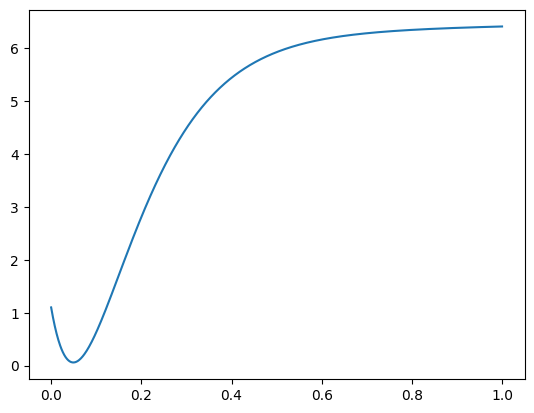

In [41]:
y = []
import numpy as np
x = np.linspace(0, 1, 1001)
for i in x:
  y.append(sc(i))

import matplotlib.pyplot as plt

plt.plot(x, y)

In [46]:
from helper.synthesis import generate_grid_data, generate_pointwise_data

In [47]:
generate_grid_data(parameterization = 'svensson')

100%|██████████| 44000/44000 [19:33<00:00, 37.48it/s]


Data successfully generated!


In [48]:
generate_pointwise_data(parameterization = 'svensson')

Data successfully generated!
